# Common libraries

In [1]:
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'12',
          'legend.fontsize':'14',
          'lines.linewidth':'2',
          'font.weight':'bold', 
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')

import time
import numpy as np
import pandas as pd
import pickle
import csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage
from numba import jit
import os

# Importing Pure Frequency Oracles from multi_freq_ldpy

In [2]:
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client, GRR_Aggregator_MI, GRR_Aggregator_IBU
from multi_freq_ldpy.pure_frequency_oracles.UE import UE_Client, UE_Aggregator_MI, UE_Aggregator_IBU
from multi_freq_ldpy.pure_frequency_oracles.LH import LH_Client, LH_Aggregator_MI, LH_Aggregator_IBU
from multi_freq_ldpy.pure_frequency_oracles.SS import SS_Client, SS_Aggregator_MI, SS_Aggregator_IBU
from multi_freq_ldpy.pure_frequency_oracles.HE import HE_Client, HE_Aggregator_MI, HE_Aggregator_IBU

# Functions

In [3]:
def categorize(x, divisions):
    for i in range(len(divisions)-2):
        if divisions[i]<=x<divisions[i+1]:
            return i
    if x>=divisions[-2]: 
        return i
    
def write(folder_name, name, values):
    with open(folder_name + "/" + name + '_results.csv', mode='a', newline='') as scores_file:
        scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        scores_writer.writerow(values)
    scores_file.close()
    
@jit(nopython=True)
def setting_seed(seed):
    np.random.seed(seed)

# Real Data : Utility Gain Analysis

In [4]:
# ---------------------------------------------
# Parameters
# ---------------------------------------------

# Folder
folder_name = "results/"

# File name
file_name = "sfe_real_data"

# List of epsilon values
lst_eps = [1, 2, 4, 8]

# Number of seeds per epsilon
seeds = np.arange(0,1) 

# Number of samples
n_size = [20000, 100000] 

# Number of categories
k_size = [2, 50, 100, 200]

# List of states for extracting income's data
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
           'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
           'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
           'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

# Error functions
err_functions = ["max_abs"] # , "mse", "mae", "max_squared"

# List of Protocols
protocols = ["GRR", "SUE", "OUE", "BLH", "OLH", "SS", "THE"]

# Distributions to test
type_dist = 'real_data'

# Header of results file
header = ["type_dist", "n", "k", "err_func", "eps", "seed",
          "mse_GRR_mi", "mse_GRR_ibu", "mse_GRR_gain", 
          "mse_SUE_mi", "mse_SUE_ibu", "mse_SUE_gain",
          "mse_OUE_mi", "mse_OUE_ibu", "mse_OUE_gain",
          "mse_BLH_mi", "mse_BLH_ibu", "mse_BLH_gain",
          "mse_OLH_mi", "mse_OLH_ibu", "mse_OLH_gain",
          "mse_SS_mi", "mse_SS_ibu", "mse_SS_gain",
          "mse_THE_mi", "mse_THE_ibu", "mse_THE_gain",
          "mae_GRR_mi", "mae_GRR_ibu", "mae_GRR_gain",
          "mae_SUE_mi", "mae_SUE_ibu", "mae_SUE_gain",
          "mae_OUE_mi", "mae_OUE_ibu", "mae_OUE_gain",
          "mae_BLH_mi", "mae_BLH_ibu", "mae_BLH_gain",
          "mae_OLH_mi", "mae_OLH_ibu", "mae_OLH_gain",
          "mae_SS_mi", "mae_SS_ibu", "mae_SS_gain",
          "mae_THE_mi", "mae_THE_ibu", "mae_THE_gain",
         ]

In [ ]:
starttime = time.time()

# Writing header
write(folder_name, file_name, header)


# ---------------------------------------------
# Building datasets
# ---------------------------------------------
for n in n_size:
    
    # ---------------------------------------------
    # New dataset
    # ---------------------------------------------
    df = pd.DataFrame()
    
    # Extracting data
    for state in states:
    
        try:
            data_source = ACSDataSource(survey_year='2018', horizon='5-Year', survey='person')
            acs_data = data_source.get_data(states=[state], download=True) 
            dfaux = acs_data[['AGEP', 'PINCP', 'WKHP', 'PWGTP']]
            dfaux = dfaux[dfaux['AGEP'] > 16]
            dfaux = dfaux[dfaux['PINCP'] > 100]
            dfaux = dfaux[dfaux['WKHP'] > 0]
            dfaux = dfaux[dfaux['PWGTP'] >= 1]
            dfaux.dropna(inplace=True)
            dfaux.drop(['AGEP', 'WKHP', 'PWGTP'], axis=1, inplace=True)
            df = pd.concat([df,dfaux], axis=0)

            # Cutting according to n
            if len(df)>n:
                df = df.iloc[:int(n)]
                break
        except:
            print("State " + state + " not found, trying with other state")
    
    # Reseting index
    df.reset_index(inplace=True)
    
    # Saving dataset
    df.to_excel(folder_name + "data_n"+str(len(df))+".xlsx")
    
    # ---------------------------------------------
    # Generating different distributions
    # ---------------------------------------------
    
    # Original reports
    original_reports = df["PINCP"].values
    
    for k in k_size:
        
        # Categorizing original reports
        _, div = np.histogram(original_reports, bins=k+1)
        real_reports = [categorize(rep,div) for rep in original_reports]
        
        # Real normalized frequency
        real_count = np.zeros(k)
        for i in real_reports:
            real_count[i] += 1
        real_freq = real_count / n
        
        # error function
        for err_func in err_functions:

            # Test name
            test_name = type_dist+"_ef"+err_func+"_n" + str(int(n)) + "_k" + str(k)
            
            # For each epsilon
            for eps in lst_eps:

                print("test: ", test_name + "_e" + str(eps))

                # For each seed
                for seed in seeds:
                    setting_seed(seed)

                    # ---------------------------------------------
                    # Applying LDP protocols
                    # ---------------------------------------------

                    # GRR protocol
                    grr_reports = [GRR_Client(input_data, k, eps) for input_data in real_reports]
                    grr_est_freq_mi = GRR_Aggregator_MI(grr_reports, k, eps)
                    grr_est_freq_ibu = GRR_Aggregator_IBU(grr_reports, k, eps, err_func=err_func)

                    # SUE protocol
                    sue_reports = [UE_Client(input_data, k, eps, optimal=False) for input_data in real_reports]
                    sue_est_freq_mi = UE_Aggregator_MI(sue_reports, eps, False)
                    sue_est_freq_ibu = UE_Aggregator_IBU(sue_reports, k, eps, False, err_func=err_func)

                    # OUE protocol
                    oue_reports = [UE_Client(input_data, k, eps, True) for input_data in real_reports]
                    oue_est_freq_mi = UE_Aggregator_MI(oue_reports, eps, True)
                    oue_est_freq_ibu = UE_Aggregator_IBU(oue_reports, k, eps, True, err_func=err_func)

                    # BLH protocol        
                    blh_reports = [LH_Client(input_data, k, eps, optimal=False) for input_data in real_reports]
                    blh_est_freq_mi = LH_Aggregator_MI(blh_reports, k, eps, False)
                    blh_est_freq_ibu = LH_Aggregator_IBU(blh_reports, k, eps, False, err_func=err_func)

                    # OLH protocol       
                    olh_reports = [LH_Client(input_data, k, eps, optimal=True) for input_data in real_reports]
                    olh_est_freq_mi = LH_Aggregator_MI(olh_reports, k, eps, True)
                    olh_est_freq_ibu = LH_Aggregator_IBU(olh_reports, k, eps, True, err_func=err_func)

                    # SS protocol       
                    ss_reports = [SS_Client(input_data, k, eps) for input_data in real_reports]
                    ss_est_freq_mi = SS_Aggregator_MI(ss_reports, k, eps)
                    ss_est_freq_ibu = SS_Aggregator_IBU(ss_reports, k, eps, err_func=err_func)

                    # THE protocol (same resports from HE but different aggregation)
                    the_reports = [HE_Client(input_data, k, eps) for input_data in real_reports]
                    the_est_freq_mi = HE_Aggregator_MI(the_reports, k, eps, True)
                    the_est_freq_ibu = HE_Aggregator_IBU(the_reports, k, eps, True, err_func=err_func)

                    # ---------------------------------------------
                    # Calculating metrics
                    # ---------------------------------------------

                    # MSE
                    mse_GRR_mi = mean_squared_error(real_freq, grr_est_freq_mi)
                    mse_GRR_ibu = mean_squared_error(real_freq, grr_est_freq_ibu)
                    mse_GRR_gain = ((mse_GRR_mi-mse_GRR_ibu)/mse_GRR_mi).clip(0)

                    mse_SUE_mi = mean_squared_error(real_freq, sue_est_freq_mi)
                    mse_SUE_ibu = mean_squared_error(real_freq, sue_est_freq_ibu)
                    mse_SUE_gain = ((mse_SUE_mi-mse_SUE_ibu)/mse_SUE_mi).clip(0)

                    mse_OUE_mi = mean_squared_error(real_freq, oue_est_freq_mi)
                    mse_OUE_ibu = mean_squared_error(real_freq, oue_est_freq_ibu)
                    mse_OUE_gain = ((mse_OUE_mi-mse_OUE_ibu)/mse_OUE_mi).clip(0)

                    mse_BLH_mi = mean_squared_error(real_freq, blh_est_freq_mi)
                    mse_BLH_ibu = mean_squared_error(real_freq, blh_est_freq_ibu)
                    mse_BLH_gain = ((mse_BLH_mi-mse_BLH_ibu)/mse_BLH_mi).clip(0)

                    mse_OLH_mi = mean_squared_error(real_freq, olh_est_freq_mi)
                    mse_OLH_ibu = mean_squared_error(real_freq, olh_est_freq_ibu)
                    mse_OLH_gain = ((mse_OLH_mi-mse_OLH_ibu)/mse_OLH_mi).clip(0)

                    mse_SS_mi = mean_squared_error(real_freq, ss_est_freq_mi)
                    mse_SS_ibu = mean_squared_error(real_freq, ss_est_freq_ibu)
                    mse_SS_gain = ((mse_SS_mi-mse_SS_ibu)/mse_SS_mi).clip(0)

                    mse_THE_mi = mean_squared_error(real_freq, the_est_freq_mi)
                    mse_THE_ibu = mean_squared_error(real_freq, the_est_freq_ibu)
                    mse_THE_gain = ((mse_THE_mi-mse_THE_ibu)/mse_THE_mi).clip(0)

                    # MAE
                    mae_GRR_mi = mean_absolute_error(real_freq, grr_est_freq_mi)
                    mae_GRR_ibu = mean_absolute_error(real_freq, grr_est_freq_ibu)
                    mae_GRR_gain = ((mae_GRR_mi-mae_GRR_ibu)/mae_GRR_mi).clip(0)

                    mae_SUE_mi = mean_absolute_error(real_freq, sue_est_freq_mi)
                    mae_SUE_ibu = mean_absolute_error(real_freq, sue_est_freq_ibu)
                    mae_SUE_gain = ((mae_SUE_mi-mae_SUE_ibu)/mae_SUE_mi).clip(0)

                    mae_OUE_mi = mean_absolute_error(real_freq, oue_est_freq_mi)
                    mae_OUE_ibu = mean_absolute_error(real_freq, oue_est_freq_ibu)
                    mae_OUE_gain = ((mae_OUE_mi-mae_OUE_ibu)/mae_OUE_mi).clip(0)

                    mae_BLH_mi = mean_absolute_error(real_freq, blh_est_freq_mi)
                    mae_BLH_ibu = mean_absolute_error(real_freq, blh_est_freq_ibu)
                    mae_BLH_gain = ((mae_BLH_mi-mae_BLH_ibu)/mae_BLH_mi).clip(0)

                    mae_OLH_mi = mean_absolute_error(real_freq, olh_est_freq_mi)
                    mae_OLH_ibu = mean_absolute_error(real_freq, olh_est_freq_ibu)
                    mae_OLH_gain = ((mae_OLH_mi-mae_OLH_ibu)/mae_OLH_mi).clip(0)

                    mae_SS_mi = mean_absolute_error(real_freq, ss_est_freq_mi)
                    mae_SS_ibu = mean_absolute_error(real_freq, ss_est_freq_ibu)
                    mae_SS_gain = ((mae_SS_mi-mae_SS_ibu)/mae_SS_mi).clip(0)

                    mae_THE_mi = mean_absolute_error(real_freq, the_est_freq_mi)
                    mae_THE_ibu = mean_absolute_error(real_freq, the_est_freq_ibu)
                    mae_THE_gain = ((mae_THE_mi-mae_THE_ibu)/mae_THE_mi).clip(0)

                    write(folder_name, file_name, 
                          [type_dist, n, k, err_func, eps, seed,
                           mse_GRR_mi, mse_GRR_ibu, mse_GRR_gain, 
                           mse_SUE_mi, mse_SUE_ibu, mse_SUE_gain,
                           mse_OUE_mi, mse_OUE_ibu, mse_OUE_gain,
                           mse_BLH_mi, mse_BLH_ibu, mse_BLH_gain,
                           mse_OLH_mi, mse_OLH_ibu, mse_OLH_gain,
                           mse_SS_mi, mse_SS_ibu, mse_SS_gain,
                           mse_THE_mi, mse_THE_ibu, mse_THE_gain,
                           mae_GRR_mi, mae_GRR_ibu, mae_GRR_gain,
                           mae_SUE_mi, mae_SUE_ibu, mae_SUE_gain,
                           mae_OUE_mi, mae_OUE_ibu, mae_OUE_gain,
                           mae_BLH_mi, mae_BLH_ibu, mae_BLH_gain,
                           mae_OLH_mi, mae_OLH_ibu, mae_OLH_gain,
                           mae_SS_mi, mae_SS_ibu, mae_SS_gain,
                           mae_THE_mi, mae_THE_ibu, mae_THE_gain,
                          ]
                         )

print('That took {} seconds'.format(time.time() - starttime))

test:  real_data_efmax_abs_n20000_k2_e1
test:  real_data_efmax_abs_n20000_k2_e2
test:  real_data_efmax_abs_n20000_k2_e4
test:  real_data_efmax_abs_n20000_k2_e8
test:  real_data_efmax_abs_n20000_k50_e1
test:  real_data_efmax_abs_n20000_k50_e2
test:  real_data_efmax_abs_n20000_k50_e4
test:  real_data_efmax_abs_n20000_k50_e8
test:  real_data_efmax_abs_n20000_k100_e1
test:  real_data_efmax_abs_n20000_k100_e2
test:  real_data_efmax_abs_n20000_k100_e4
test:  real_data_efmax_abs_n20000_k100_e8
test:  real_data_efmax_abs_n20000_k200_e1
test:  real_data_efmax_abs_n20000_k200_e2
test:  real_data_efmax_abs_n20000_k200_e4
test:  real_data_efmax_abs_n20000_k200_e8
test:  real_data_efmax_abs_n100000_k2_e1
test:  real_data_efmax_abs_n100000_k2_e2
test:  real_data_efmax_abs_n100000_k2_e4
test:  real_data_efmax_abs_n100000_k2_e8
test:  real_data_efmax_abs_n100000_k50_e1
test:  real_data_efmax_abs_n100000_k50_e2
test:  real_data_efmax_abs_n100000_k50_e4
test:  real_data_efmax_abs_n100000_k50_e8
test:  r

# Real Data : Plotting Utility Gain

In [ ]:
# Styles
font_size_title = 20

# Epsilon values to be plotted
lst_eps = [1, 2, 4]

# Metrics to plot
lst_metrics = [("MSE", "mse"), 
              ]

# Reading results
df = pd.DataFrame()
for file in os.listdir(folder_name):
    if file.endswith("csv"):
        df = pd.concat([df, pd.read_csv(folder_name + file)], axis=0)

# Plotting all results
for metric in lst_metrics:
        for n in n_size:
            for k in k_size:
                for err_func in err_functions:
                    
                    fig, ax = plt.subplots(nrows=1, ncols=len(lst_eps), figsize=(24,5))
                    fig.tight_layout(w_pad=1.0)
                    test_name = "Real_data" + ", n=" + str(n) + ", k=" + str(k)
                    
                    for idx, eps in enumerate(lst_eps):
                        dfaux = df.loc[(df["type_dist"]==type_dist) & (df["n"]==n) & (df["k"]==k) & (df["err_func"]==err_func) & (df["eps"]==eps)]

                        dfplot = pd.DataFrame()
                        dfplot["protocols"] = protocols
                        for estimator in ["mi", "ibu"]:
                            lst = []
                            for protocol in protocols:
                                lst.append(dfaux[metric[1]+"_"+protocol+"_"+estimator].mean())
                            dfplot[estimator.upper()] = lst

                        dfplot["GAIN"] = ((dfplot["MI"]-dfplot["IBU"])/dfplot["MI"]).clip(0)
                        dfplot.set_index("protocols", inplace=True)
                        gains = np.round(dfplot["GAIN"].values*100)

                        # plotting
                        dfplot.drop(["GAIN"], axis=1).plot.bar(rot=0, width=0.8, ax=ax[idx]) #,stacked=True, width=1
                        ax[idx].set_title(test_name+", $\epsilon$="+str(eps)+", AvgGain="+str(round(dfplot["GAIN"].mean()*100))+"%", fontsize=font_size_title)
                        if idx==0:
                            ax[idx].set_ylabel(metric[0]+' in Log scale', fontsize=font_size_title)
                        ax[idx].set_xlabel('LDP Protocols', fontsize=font_size_title)
                        ax[idx].set_yscale('log')
                        ax[idx].grid(color='grey', linestyle='dashdot', linewidth=0.5, alpha=0.5)
                        for i,j in zip(range(len(gains)), range(len(gains), len(gains)*2)):  
                            h = max(ax[idx].patches[i].get_height(), ax[idx].patches[j].get_height())
                            ax[idx].annotate("$\Gamma$="+str(int(gains[i]))+"%", (ax[idx].patches[i].get_x()*1.005-0.01, h * 1.1)) # -0.1 
                        maxh = max([ax[idx].patches[i].get_height() for i in range(len(gains)*2)])
                        maxh = maxh*4
                        maxv = ax[idx].patches[i].get_x()*1.15
                        ax[idx].set_ylim(top=maxh)
                        ax[idx].set_xlim(right=maxv)
                        ax[idx].legend(ncol=2)

                    plt.savefig(folder_name + 'IMG_UG_'+test_name+'.pdf', dpi=300, bbox_inches='tight')



# Artificial Data : Utility Gain Analysis

In [4]:
# ---------------------------------------------
# Parameters
# ---------------------------------------------

# Folder
folder_name = "results/"

# File name
file_name = "sfe_artificial_data"

# List of epsilon values
lst_eps = [1, 2, 4, 8] 

# Number of seeds per epsilon
seeds = np.arange(0,20) 

# Number of samples
n_size = [20000, 100000] 

# Number of categories
k_size = [2, 50, 100, 200] 

# Distributions to test
distributions = ["Gaussian", "Exponential", "Uniform", "Poisson", "Triangular"] 

# Error functions
err_functions = ["max_abs"] # , "mse", "mae", "max_squared"

# List of Protocols
protocols = ["GRR", "SUE", "OUE", "BLH", "OLH", "SS", "THE"]

# Header of results file
header = ["type_dist", "n", "k", "err_func", "eps", "seed",
          "mse_GRR_mi", "mse_GRR_ibu", "mse_GRR_gain", 
          "mse_SUE_mi", "mse_SUE_ibu", "mse_SUE_gain",
          "mse_OUE_mi", "mse_OUE_ibu", "mse_OUE_gain",
          "mse_BLH_mi", "mse_BLH_ibu", "mse_BLH_gain",
          "mse_OLH_mi", "mse_OLH_ibu", "mse_OLH_gain",
          "mse_SS_mi", "mse_SS_ibu", "mse_SS_gain",
          "mse_THE_mi", "mse_THE_ibu", "mse_THE_gain",
          "mae_GRR_mi", "mae_GRR_ibu", "mae_GRR_gain",
          "mae_SUE_mi", "mae_SUE_ibu", "mae_SUE_gain",
          "mae_OUE_mi", "mae_OUE_ibu", "mae_OUE_gain",
          "mae_BLH_mi", "mae_BLH_ibu", "mae_BLH_gain",
          "mae_OLH_mi", "mae_OLH_ibu", "mae_OLH_gain",
          "mae_SS_mi", "mae_SS_ibu", "mae_SS_gain",
          "mae_THE_mi", "mae_THE_ibu", "mae_THE_gain",
         ]

In [5]:
starttime = time.time()

# writing header
write(folder_name, file_name, header)

# ---------------------------------------------
# Dataset according to the type of distribution 
# ---------------------------------------------
for type_dist in distributions:

    # Dataset size
    for n in n_size:

        # Original reports
        original_reports = None
        if type_dist=="Gaussian":
            mu = 1000
            sigma = 100
            original_reports = np.random.normal(mu, sigma, n)

        elif type_dist=="Exponential":
            scale = 1
            original_reports = np.random.exponential(scale, n)

        elif type_dist=="Uniform":
            low = 100
            high = 10000
            original_reports = np.random.uniform(low, high,n)

        elif type_dist=="Poisson":
            lam = 5
            original_reports = np.random.poisson(lam, n)
            
        elif type_dist=="Triangular":
            left = 100
            mode = 4500
            right = 10000
            original_reports = np.random.triangular(left, mode, right, size=n)
            
        else:
            raise ValueError('Distribution not unknown')

        # Number of categories
        for k in k_size:

            # Categorizing original reports
            _, div = np.histogram(original_reports, bins=k+1)
            real_reports = [categorize(rep,div) for rep in original_reports]

            # Real normalized frequency
            real_count = np.zeros(k)
            for i in real_reports:
                real_count[i] += 1
            real_freq = real_count / n

            # error function
            for err_func in err_functions:

                # Test name
                test_name = type_dist+"_ef"+err_func+"_n" + str(int(n)) + "_k" + str(k)

                # For each epsilon
                for eps in lst_eps:

                    print("test: ", test_name + "_e" + str(eps))

                    # For each seed
                    for seed in seeds:
                        
                        setting_seed(seed)
                        
                        # ---------------------------------------------
                        # Applying LDP protocols
                        # ---------------------------------------------

                        # GRR protocol
                        grr_reports = [GRR_Client(input_data, k, eps) for input_data in real_reports]
                        grr_est_freq_mi = GRR_Aggregator_MI(grr_reports, k, eps)
                        grr_est_freq_ibu = GRR_Aggregator_IBU(grr_reports, k, eps, err_func=err_func)

                        # SUE protocol
                        sue_reports = [UE_Client(input_data, k, eps, optimal=False) for input_data in real_reports]
                        sue_est_freq_mi = UE_Aggregator_MI(sue_reports, eps, False)
                        sue_est_freq_ibu = UE_Aggregator_IBU(sue_reports, k, eps, False, err_func=err_func)

                        # OUE protocol
                        oue_reports = [UE_Client(input_data, k, eps, True) for input_data in real_reports]
                        oue_est_freq_mi = UE_Aggregator_MI(oue_reports, eps, True)
                        oue_est_freq_ibu = UE_Aggregator_IBU(oue_reports, k, eps, True, err_func=err_func)

                        # BLH protocol        
                        blh_reports = [LH_Client(input_data, k, eps, optimal=False) for input_data in real_reports]
                        blh_est_freq_mi = LH_Aggregator_MI(blh_reports, k, eps, False)
                        blh_est_freq_ibu = LH_Aggregator_IBU(blh_reports, k, eps, False, err_func=err_func)

                        # OLH protocol       
                        olh_reports = [LH_Client(input_data, k, eps, optimal=True) for input_data in real_reports]
                        olh_est_freq_mi = LH_Aggregator_MI(olh_reports, k, eps, True)
                        olh_est_freq_ibu = LH_Aggregator_IBU(olh_reports, k, eps, True, err_func=err_func)

                        # SS protocol       
                        ss_reports = [SS_Client(input_data, k, eps) for input_data in real_reports]
                        ss_est_freq_mi = SS_Aggregator_MI(ss_reports, k, eps)
                        ss_est_freq_ibu = SS_Aggregator_IBU(ss_reports, k, eps, err_func=err_func)

                        # THE protocol (same resports from HE but different aggregation)
                        the_reports = [HE_Client(input_data, k, eps) for input_data in real_reports]
                        the_est_freq_mi = HE_Aggregator_MI(the_reports, k, eps, True)
                        the_est_freq_ibu = HE_Aggregator_IBU(the_reports, k, eps, True, err_func=err_func)

                        # ---------------------------------------------
                        # Calculating metrics
                        # ---------------------------------------------
                        
                        # MSE
                        mse_GRR_mi = mean_squared_error(real_freq, grr_est_freq_mi)
                        mse_GRR_ibu = mean_squared_error(real_freq, grr_est_freq_ibu)
                        mse_GRR_gain = ((mse_GRR_mi-mse_GRR_ibu)/mse_GRR_mi).clip(0)

                        mse_SUE_mi = mean_squared_error(real_freq, sue_est_freq_mi)
                        mse_SUE_ibu = mean_squared_error(real_freq, sue_est_freq_ibu)
                        mse_SUE_gain = ((mse_SUE_mi-mse_SUE_ibu)/mse_SUE_mi).clip(0)

                        mse_OUE_mi = mean_squared_error(real_freq, oue_est_freq_mi)
                        mse_OUE_ibu = mean_squared_error(real_freq, oue_est_freq_ibu)
                        mse_OUE_gain = ((mse_OUE_mi-mse_OUE_ibu)/mse_OUE_mi).clip(0)

                        mse_BLH_mi = mean_squared_error(real_freq, blh_est_freq_mi)
                        mse_BLH_ibu = mean_squared_error(real_freq, blh_est_freq_ibu)
                        mse_BLH_gain = ((mse_BLH_mi-mse_BLH_ibu)/mse_BLH_mi).clip(0)

                        mse_OLH_mi = mean_squared_error(real_freq, olh_est_freq_mi)
                        mse_OLH_ibu = mean_squared_error(real_freq, olh_est_freq_ibu)
                        mse_OLH_gain = ((mse_OLH_mi-mse_OLH_ibu)/mse_OLH_mi).clip(0)

                        mse_SS_mi = mean_squared_error(real_freq, ss_est_freq_mi)
                        mse_SS_ibu = mean_squared_error(real_freq, ss_est_freq_ibu)
                        mse_SS_gain = ((mse_SS_mi-mse_SS_ibu)/mse_SS_mi).clip(0)

                        mse_THE_mi = mean_squared_error(real_freq, the_est_freq_mi)
                        mse_THE_ibu = mean_squared_error(real_freq, the_est_freq_ibu)
                        mse_THE_gain = ((mse_THE_mi-mse_THE_ibu)/mse_THE_mi).clip(0)

                        # MAE
                        mae_GRR_mi = mean_absolute_error(real_freq, grr_est_freq_mi)
                        mae_GRR_ibu = mean_absolute_error(real_freq, grr_est_freq_ibu)
                        mae_GRR_gain = ((mae_GRR_mi-mae_GRR_ibu)/mae_GRR_mi).clip(0)

                        mae_SUE_mi = mean_absolute_error(real_freq, sue_est_freq_mi)
                        mae_SUE_ibu = mean_absolute_error(real_freq, sue_est_freq_ibu)
                        mae_SUE_gain = ((mae_SUE_mi-mae_SUE_ibu)/mae_SUE_mi).clip(0)

                        mae_OUE_mi = mean_absolute_error(real_freq, oue_est_freq_mi)
                        mae_OUE_ibu = mean_absolute_error(real_freq, oue_est_freq_ibu)
                        mae_OUE_gain = ((mae_OUE_mi-mae_OUE_ibu)/mae_OUE_mi).clip(0)

                        mae_BLH_mi = mean_absolute_error(real_freq, blh_est_freq_mi)
                        mae_BLH_ibu = mean_absolute_error(real_freq, blh_est_freq_ibu)
                        mae_BLH_gain = ((mae_BLH_mi-mae_BLH_ibu)/mae_BLH_mi).clip(0)

                        mae_OLH_mi = mean_absolute_error(real_freq, olh_est_freq_mi)
                        mae_OLH_ibu = mean_absolute_error(real_freq, olh_est_freq_ibu)
                        mae_OLH_gain = ((mae_OLH_mi-mae_OLH_ibu)/mae_OLH_mi).clip(0)

                        mae_SS_mi = mean_absolute_error(real_freq, ss_est_freq_mi)
                        mae_SS_ibu = mean_absolute_error(real_freq, ss_est_freq_ibu)
                        mae_SS_gain = ((mae_SS_mi-mae_SS_ibu)/mae_SS_mi).clip(0)

                        mae_THE_mi = mean_absolute_error(real_freq, the_est_freq_mi)
                        mae_THE_ibu = mean_absolute_error(real_freq, the_est_freq_ibu)
                        mae_THE_gain = ((mae_THE_mi-mae_THE_ibu)/mae_THE_mi).clip(0)
                        
                        write(folder_name, file_name, 
                              [type_dist, n, k, err_func, eps, seed,
                               mse_GRR_mi, mse_GRR_ibu, mse_GRR_gain, 
                               mse_SUE_mi, mse_SUE_ibu, mse_SUE_gain,
                               mse_OUE_mi, mse_OUE_ibu, mse_OUE_gain,
                               mse_BLH_mi, mse_BLH_ibu, mse_BLH_gain,
                               mse_OLH_mi, mse_OLH_ibu, mse_OLH_gain,
                               mse_SS_mi, mse_SS_ibu, mse_SS_gain,
                               mse_THE_mi, mse_THE_ibu, mse_THE_gain,
                               mae_GRR_mi, mae_GRR_ibu, mae_GRR_gain,
                               mae_SUE_mi, mae_SUE_ibu, mae_SUE_gain,
                               mae_OUE_mi, mae_OUE_ibu, mae_OUE_gain,
                               mae_BLH_mi, mae_BLH_ibu, mae_BLH_gain,
                               mae_OLH_mi, mae_OLH_ibu, mae_OLH_gain,
                               mae_SS_mi, mae_SS_ibu, mae_SS_gain,
                               mae_THE_mi, mae_THE_ibu, mae_THE_gain,
                              ]
                             )
                        
print('That took {} seconds'.format(time.time() - starttime))

test:  Gaussian_efmax_abs_n20000_k2_e1
test:  Gaussian_efmax_abs_n20000_k2_e2
test:  Gaussian_efmax_abs_n20000_k2_e4
test:  Gaussian_efmax_abs_n20000_k2_e8
test:  Gaussian_efmax_abs_n20000_k50_e1
test:  Gaussian_efmax_abs_n20000_k50_e2
test:  Gaussian_efmax_abs_n20000_k50_e4
test:  Gaussian_efmax_abs_n20000_k50_e8
test:  Gaussian_efmax_abs_n20000_k100_e1
test:  Gaussian_efmax_abs_n20000_k100_e2
test:  Gaussian_efmax_abs_n20000_k100_e4
test:  Gaussian_efmax_abs_n20000_k100_e8
test:  Gaussian_efmax_abs_n20000_k200_e1
test:  Gaussian_efmax_abs_n20000_k200_e2
test:  Gaussian_efmax_abs_n20000_k200_e4
test:  Gaussian_efmax_abs_n20000_k200_e8
test:  Exponential_efmax_abs_n20000_k2_e1
test:  Exponential_efmax_abs_n20000_k2_e2
test:  Exponential_efmax_abs_n20000_k2_e4
test:  Exponential_efmax_abs_n20000_k2_e8
test:  Exponential_efmax_abs_n20000_k50_e1
test:  Exponential_efmax_abs_n20000_k50_e2
test:  Exponential_efmax_abs_n20000_k50_e4
test:  Exponential_efmax_abs_n20000_k50_e8
test:  Exponenti

# Artificial Data : Plotting Utility Gain

In [6]:
# Epsilon values to be plotted
lst_eps = [1, 2, 4]

# Sample sizes to be plotted
n_size = [20000, 100000]

# Styles
font_size_title = 20

# Metric to plot
lst_metrics = [("MSE", "mse"), 
              ]

# Reading results
df = pd.DataFrame()
for file in os.listdir(folder_name):
    if file.endswith("csv"):
        df = pd.concat([df, pd.read_csv(folder_name + file)], axis=0)

# Plotting all results
for metric in lst_metrics:
    for type_dist in distributions:
        for n in n_size:
            for k in k_size:
                for err_func in err_functions:
                    
                    fig, ax = plt.subplots(nrows=1, ncols=len(lst_eps), figsize=(24,5))
                    fig.tight_layout(w_pad=1.0)
                    test_name = type_dist + ", n=" + str(n) + ", k=" + str(k)
                    
                    for idx, eps in enumerate(lst_eps):
                        dfaux = df.loc[(df["type_dist"]==type_dist) & (df["n"]==n) & (df["k"]==k) & (df["err_func"]==err_func) & (df["eps"]==eps)]

                        dfplot = pd.DataFrame()
                        dfplot["protocols"] = protocols
                        for estimator in ["mi", "ibu"]:
                            lst = []
                            for protocol in protocols:
                                lst.append(dfaux[metric[1]+"_"+protocol+"_"+estimator].mean())
                            dfplot[estimator.upper()] = lst

                        dfplot["GAIN"] = ((dfplot["MI"]-dfplot["IBU"])/dfplot["MI"]).clip(0)
                        dfplot.set_index("protocols", inplace=True)
                        gains = np.round(dfplot["GAIN"].values*100)

                        # plotting
                        dfplot.drop(["GAIN"], axis=1).plot.bar(rot=0, width=0.8, ax=ax[idx]) 
                        ax[idx].set_title(test_name+", $\epsilon$="+str(eps)+", AvgGain="+str(round(dfplot["GAIN"].mean()*100))+"%", fontsize=font_size_title)
                        if idx==0:
                            ax[idx].set_ylabel(metric[0]+' in Log scale', fontsize=font_size_title)
                        ax[idx].set_xlabel('LDP Protocols', fontsize=font_size_title)
                        ax[idx].set_yscale('log')
                        ax[idx].grid(color='grey', linestyle='dashdot', linewidth=0.5, alpha=0.5)
                        for i,j in zip(range(len(gains)), range(len(gains), len(gains)*2)):  
                            h = max(ax[idx].patches[i].get_height(), ax[idx].patches[j].get_height())
                            ax[idx].annotate("$\Gamma$="+str(int(gains[i]))+"%", (ax[idx].patches[i].get_x()*1.005-0.01, h * 1.1)) # -0.1 
                        maxh = max([ax[idx].patches[i].get_height() for i in range(len(gains)*2)])
                        maxh = maxh*4
                        maxv = ax[idx].patches[i].get_x()*1.15
                        ax[idx].set_ylim(top=maxh)
                        ax[idx].set_xlim(right=maxv)
                        ax[idx].legend(ncol=2)

                    plt.savefig(folder_name + 'IMG_UG_'+test_name+'.pdf', dpi=300, bbox_inches='tight')



NameError: name 'distributions' is not defined

eps red 1
eps orange 2
eps yellow 4
n purple 20000
n yellow 100000
k purple 2
k red 50
k orange 100
k yellow 200


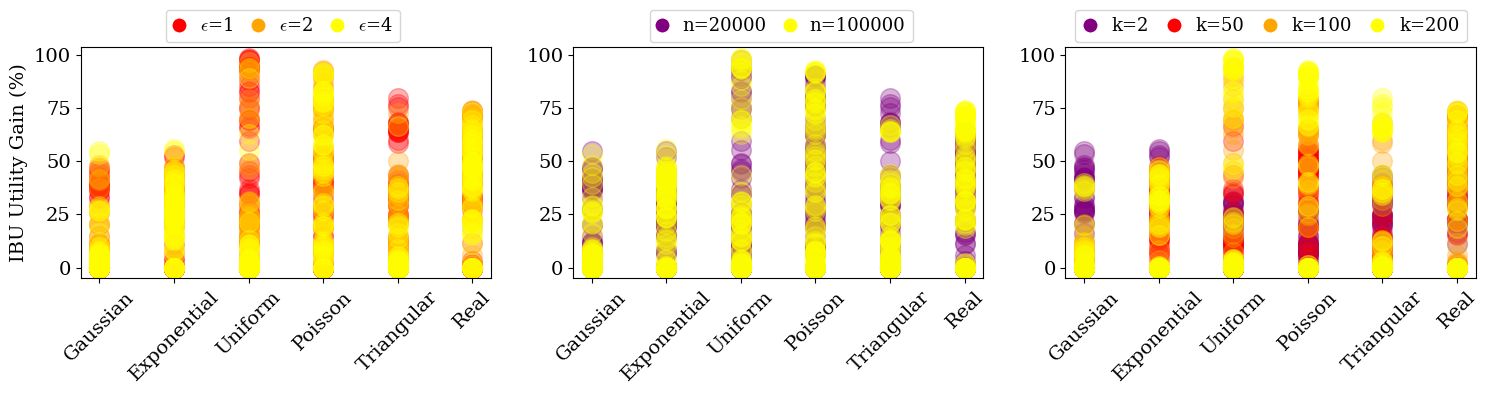

eps red 1
eps orange 2
eps yellow 4
n purple 20000
n yellow 100000
k purple 2
k red 50
k orange 100
k yellow 200


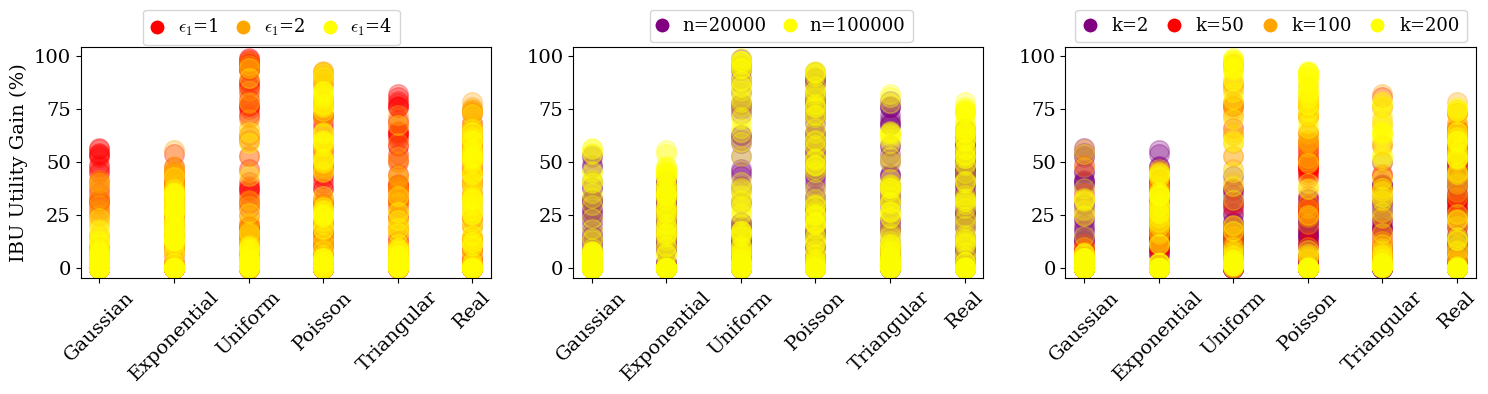

In [48]:
from matplotlib.lines import Line2D

# List of Protocols
protocols = ["GRR", "SUE", "OUE", "BLH", "OLH", "SS", "THE"]

# Directory
directory = "results"

# Prefix
prefix = ""

# List of epsilon values
lst_eps = [1, 2, 4] 

# Number of samples
n_size = [20000, 100000] 

# Number of categories
k_size = [2, 50, 100, 200] 

# Distributions to test
distributions = ["Gaussian", "Exponential", "Uniform", "Poisson", "Triangular", "Real"]

# Error functions
err_func = "max_abs" 

# Metric 
metric = "mse"


# Plotting all results
# --------------------

# Reading results
df = pd.DataFrame()
for file in os.listdir(directory):
    if file.endswith("csv"):
        df = pd.concat([df, pd.read_csv(directory + "/" + file)], axis=0)

# Dataset with results
cols = ["type_dist", "protocol", "n", "k", "eps", "gain"]
dfaux = pd.DataFrame(columns=cols)

# Combinations  
for type_dist in distributions:
    for protocol in protocols:
        for n in n_size:
            for k in k_size:
                for eps in lst_eps:

                    mean_gain = df.loc[(df["seed"]<20) & 
                                       (df["type_dist"]==type_dist) & 
                                       (df["n"]==n) & 
                                       (df["k"]==k) & 
                                       (df["err_func"]==err_func) & 
                                       (df["eps"]==eps)][["type_dist", 
                                                          metric+"_"+prefix+protocol+"_gain"]].mean()[0]
                    combination = pd.DataFrame([[type_dist, protocol, n, k, eps, round(mean_gain*100,2)]], 
                                               columns=cols)
                    dfaux = pd.concat([dfaux,combination], axis=0)

# Plotting
fig, ax = plt.subplots(ncols=3, figsize=(18,3))
alpha = 0.3
s = 200
rotation = 45
legfontsize = 13
legmarkersize = 11

# Plotting by epsilon (eps)
ax0_legend_elements = []
for color, eps in zip(["red", "orange", "yellow"], lst_eps):
    dfaux2 = dfaux.loc[dfaux["eps"]==eps]
    ax[0].scatter(dfaux2["type_dist"].values, dfaux2["gain"].values, 
                  s=s, color=color, alpha=alpha)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = rotation)
    ax0_legend_elements.append(Line2D([0],[0], 
                                      marker='o', 
                                      color="w", 
                                      label="$\epsilon_1$="+str(eps) if prefix=="L_" else "$\epsilon$="+str(eps), 
                                      markerfacecolor = color,
                                      markersize=legmarkersize))
ax[0].legend(bbox_to_anchor=(0.8, 1.2), 
             ncols=3, columnspacing=1, handlelength=0.7,
             fontsize=legfontsize, 
             handles=ax0_legend_elements)
ax[0].set_ylabel("IBU Utility Gain (%)")


# Plotting by sample size (n)
ax1_legend_elements = []
for color, n in zip(["purple", "yellow"], n_size):
    dfaux2 = dfaux.loc[dfaux["n"]==n]
    ax[1].scatter(dfaux2["type_dist"].values, dfaux2["gain"].values, 
                  s=s, color=color, alpha=alpha)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = rotation)
    ax1_legend_elements.append(Line2D([0],[0], 
                                      marker='o', 
                                      color="w", 
                                      label="n="+str(n), 
                                      markerfacecolor = color,
                                      markersize=legmarkersize))
ax[1].legend(bbox_to_anchor=(0.85, 1.2), 
             ncols=2, columnspacing=1, handlelength=0.6,
             fontsize=legfontsize, 
             handles=ax1_legend_elements)


# Plotting by domain size (k)
ax2_legend_elements = []
for color, k in zip(["purple", "red", "orange", "yellow"], k_size):
    dfaux2 = dfaux.loc[dfaux["k"]==k]
    ax[2].scatter(dfaux2["type_dist"].values, dfaux2["gain"].values, 
                  s=s, color=color, alpha=alpha)
    ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation = rotation)
    ax2_legend_elements.append(Line2D([0],[0], 
                                      marker='o', 
                                      color="w", 
                                      label="k="+str(k), 
                                      markerfacecolor = color,
                                      markersize=legmarkersize))
ax[2].legend(bbox_to_anchor=(1, 1.2), 
             ncols=4, columnspacing=1, handlelength=0.8,
             fontsize=legfontsize, 
             handles=ax2_legend_elements)

plt.savefig(directory + "/" + 'IMG_UG_'+prefix+'eps_n_k.pdf', dpi=300, bbox_inches='tight')
plt.show()

    
